In [210]:
from collections import Counter
import os
import pandas as pd
from collections import Counter, defaultdict
from extractFeatures import getTexts,audience
from nltk import ngrams


def getgrams(txt):
    infile = open(txt,'r')
    lines = infile.readlines()
    infile.close()
    allgrams = []
    for line in lines: 
        line = line.split('--')
        ngrams = line[1].strip()
        if '_' in ngrams: 
                ngrams = ngrams.strip().split(' ')
                for n in ngrams:
                        allgrams.append(n)
        else: continue
    return allgrams 

In [211]:
csv_data = pd.read_csv('/Users/amycweng/Digital Humanities/Early-Modern-London/Sermons_Info/sermons.csv')
tcpIDs = [ _ for _ in csv_data['id']]
categories = list(set([value[0] for value in audience.values()]))
categorizedIDs = {key: [] for key in categories if 'house' not in key}
for tcpID in tcpIDs: 
    if audience[tcpID][0] in ['parliament','house of lords','house of commons']: 
        categorizedIDs['parliament'].append(tcpID)
    else: 
        categorizedIDs[audience[tcpID][0]].append(tcpID)
tcpIDs = categorizedIDs['monarch']
bigramdata = getTexts('/Users/amycweng/Digital Humanities/charityTXT',tcpIDs)
bigramtexts = list(bigramdata.values())
bigramnames = list(bigramdata.keys())
print(len(bigramnames))
''' 
Gets bigrams and trigrams that appear at least TWICE

'''
sentences = []
stopwords = ["if","an",'the','of','this','much','and','that','as','it',
             'thereby','to','be','in','by','on','only','therefore','then',
             'there','nor','but','or','either','both','which']
for t in bigramtexts:
    words = t.split(' ')
    words = [x for x in words if x not in stopwords]
    sentences.append(words)

11


In [212]:
model_2 = defaultdict(lambda: defaultdict(lambda: 0))
model_3 = defaultdict(lambda: defaultdict(lambda: 0))
model_4 = defaultdict(lambda: defaultdict(lambda: 0))
model_5 = defaultdict(lambda: defaultdict(lambda: 0))

for sentence in sentences:
    for w1, w2 in ngrams(sentence, 2, pad_right=True, pad_left=True):
        model_2[w1][w2] += 1
    for w1, w2, w3 in ngrams(sentence, 3, pad_right=True, pad_left=True):
        model_3[(w1, w2)][w3] += 1
    for w1, w2, w3, w4 in ngrams(sentence, 4, pad_right=True, pad_left=True):
        model_4[(w1, w2, w3)][w4] += 1
    for w1, w2, w3, w4,w5 in ngrams(sentence, 5, pad_right=True, pad_left=True):
        model_5[(w1, w2, w3, w4)][w5] += 1
        
from math import *
models = [model_2, model_3, model_4, model_5]
for model in models: 
    for key in model:
        total_count = float(sum(model[key].values()))
        for following in model[key]:
            prob = model[key][following] / total_count
            model[key][following] = round(prob,3)

In [204]:
import pygraphviz as pgv
def tree(start,num): 
    count = 0
    G=pgv.AGraph(directed=True)
    G.add_node(start, color='darkblue')
    step1 = Counter(dict(model_2[start])).most_common(n=num)
    for idx,tuple in enumerate(step1): 
        word,prob = tuple
        G.add_node(f"{word}_{count}",color='purple')
        count += 1 
        G.add_edge(start,f"{word}_{count}",color='black',label=prob)
        step2 = Counter(dict(model_3[start,word])).most_common(n=num)
        for idx2,tuple2 in enumerate(step2):
            word2,prob2 = tuple2
            G.add_node(f"{word2}_{count}",color='purple')
            G.add_edge(f"{word}_{count}",f"{word2}_{count}",color='black',label=prob2)
            step3 = Counter(dict(model_4[start,word,word2])).most_common(n=num)
            for idx3,tuple3 in enumerate(step3):
                word3,prob3 = tuple3
                G.add_node(f"{word3}_3_{idx3}",color='purple')
                G.add_edge(f"{word2}_2_{idx2}",f"{word3}_3_{idx3}",color='black',label=prob3)
                step4 = Counter(dict(model_5[start,word,word2,word3])).most_common(n=num)
                for idx4,tuple4 in enumerate(step4):
                    word4,prob4 = tuple4
                    G.add_node(f"{word4}_4_{idx4}",color='purple')
                    G.add_edge(f"{word3}_3_{idx3}",f"{word4}_4_{idx4}",color='black',label=prob4)
    G.layout(prog='dot') # use dot
    G.draw(f'{start}.png')

In [213]:
tree('help',3)
tree('give',3)
tree('sell',3)

In [ ]:
# charity, wealth, charitable, bestow, bequeath, give, alm
# starts = ['charity','charitable','bestow','wealth','alm','give']
starts = ['charity','charitable','bequeath','poor','poverty','beggar',"help", "provide",'feed','clothe','orphan','widow','needy','give','alm','money','beg']
starts = ['charity','poor','charitable','poverty']
starts = ['charity']
num=5
expressions = []
for start in starts: 
    step1 = Counter(dict(model_2[start])).most_common(n=num)
    expression = [start]
    print(f'{start}: {step1}')
    for idx, tuple in enumerate(step1): 
        word = tuple[0]
        if idx == 0: 
            expression.append(word)
        step2 = Counter(dict(model_3[start,word])).most_common(n=num)
        print(f'\t{word}: {step2}')
        for idx2, tuple2 in enumerate(step2): 
            word2 = tuple2[0]
            if idx==0 and idx2 == 0: 
                expression.append(word2)
            step3 = Counter(dict(model_4[start,word,word2])).most_common(n=num)
            print(f'\t\t{word2}: {step3}')
            for idx3, tuple3 in enumerate(step3): 
                word3 = tuple3[0]
                if idx==0 and idx2 == 0 and idx3 == 0: 
                    expression.append(word3)
                step4 = Counter(dict(model_5[start,word,word2,word3])).most_common(n=num)
                if len(step4) > 1: 
                    print(f'\t\t\t{word3}: {step4}')
                    if idx==0 and idx2 == 0 and idx3 == 0: 
                        expression.append(step4[0][0])
    expressions.append(' '.join(expression))
expressions

In [214]:
print(Counter(dict(model_3['her','charity'])).most_common(n=25))
print(Counter(dict(model_3['his','charity'])).most_common(n=25))
print(Counter(dict(model_3['our','charity'])).most_common(n=25))
print(Counter(dict(model_3['bestow','upon'])).most_common(n=25))
print(Counter(dict(model_2['poor'])).most_common(n=25))


[]
[]
[('with', 1.0)]
[('creature', 1.0)]
[('man', 0.08), ('for', 0.04), ('thought', 0.04), ('take', 0.04), ('blind', 0.04), ('sinner', 0.04), ('silly', 0.04), ('vine', 0.04), ('unity', 0.04), ('subject', 0.04), ('orphan', 0.04), ('truce', 0.04), ('soul', 0.04), ('perhaps', 0.04), ('amos', 0.04), ('their', 0.04), ('say', 0.04), ('despicable', 0.04), ('imperfect', 0.04), ('wretched', 0.04), ('little', 0.04), ('scrape', 0.04), ('worm', 0.04), ('windy', 0.04)]


In [14]:
'''For charity texts''' 
groups = {0: 'charity|charitable|charitie', 
        1: 'beneficience|bequeath|bestow|liberality|benevolence|goodwill| alm | almes |kindness|almsdeed',
        2: 'poor|poverty|rich|wealthy|wealth|beggar|orphan|needy|labourer|impotent|bankrup|penury|meanness|prosperity|bounty|impouerish|impoverish',
        3: 'rate|usury|usurer|money|commodity|talon|talent|coin|bullion|exchange|shilling|farthing| pound |penny|purchase',
        4: 'credit|creditor|loan|lend',
        5: ' debt|debtor|borrow|pledge|pawn',
        6: 'industry|industrious|thrift|labor|labour|occupation|profit|profitable|commodious',
        7: 'prison|imprisonment',
        8: 'hospital|almshouse|orphanage',
        9: 'city|citizen|london',
        10: 'vagrant|vagrancy'
        }
searchwords = []
for part in groups.values(): 
    searchwords.extend([word.strip() for word in part.split('|')])
# '''For plays''' 
# searchwords = ['credit','creditors','loan','lending','lend','new','nevv','novelty','novel',
#     'nouel','nouelty','nouelties','novelties','profits','profit',
#     'wealth','vvealth','merit','commodity','commoditie','money',
#     'monies','thrift','thrifty','industry'
# ]
gramDict = {}
gramFreqs = {}
for key in searchwords: 
    gramDict[key] = []
    gramFreqs[key] = 0
    
name = 'charity'
# name = 'plays'
storeGramFile = open(f'gramsEach{name}Text.txt','w')
count = 0
for idx, text in enumerate(bigramtexts):
    #for outputting to txt file, specify here
    textGrams = []
    totalgrams = 0
    text = text.strip().split(' ')
    gcount = Counter(b for b in grammodel[text] if len(b.split("_")) > 1)
    for gram,freq in dict(gcount).items():
        totalgrams += freq
        for s in searchwords: 
            if s in gram.split('_'):
                gramDict[s].append(gram)
                gramFreqs[s] += freq
                textGrams.append(" ".join([gram]*freq))

    storeGramFile.write(f'{bigramnames[idx]}: {totalgrams} -- {" ".join(textGrams)}\n')
    count += 1
    if count%10 == 0:
        print(count, "files processed")
storeGramFile.close()
with open(f'{name}Grams.txt', 'w+') as outfile: 
    for s in searchwords: 
        outfile.write(f"{s}: {gramFreqs[s]} occurrences\n\t\t{' '.join(gramDict[s])}\n")

print('processing complete')

10 files processed
20 files processed
30 files processed
40 files processed
50 files processed
60 files processed
70 files processed
processing complete


In [17]:
''' 
Mask creation code from this tutorial: https://www.holisticseo.digital/python-seo/word-cloud/
'''
import numpy as np 
from PIL import Image
mask = np.array(Image.open('/Users/amycweng/Digital Humanities/Early-Modern-London/Other_Files/heart.png'))
def transform_zeros(val):
    if val == 0:
        return 255
    else: 
        return val
maskable_image = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)
for i in range(len(mask)):
    maskable_image[i] = list(map(transform_zeros, mask[i]))

In [19]:
charitygrams = getgrams('gramsEachcharityText.txt')
counts = Counter(charitygrams)

[('be_rich', 128), ('rich_man', 115), ('poor_man', 66), ('bestow_upon', 45), ('his_wealth', 42), ('be_poor', 36), ('be_bestow', 34), ('wealth_be', 31), ('bestow_it', 28), ('this_city', 28), ('labour_to_see', 27), ('his_labour', 24), ('god_bestow', 24), ('labour_to_get', 23), ('not_profit', 23), ('their_labour', 23), ('your_labour', 22), ('we_labour', 22), ('labour_to_have', 22), ('our_labour', 22), ('he_labour', 22), ('he_bestow', 22), ('poor_sinner', 22), ('be_profitable', 21), ('his_credit', 21), ('therefore_labour', 21), ('must_labour', 20), ('thy_wealth', 20), ('labour_after', 19), ('rich_or_poor', 18), ('city_be', 18), ('that_city', 18), ('profit_not', 18), ('give_to_the_poor', 18), ('what_profit', 17), ('rich_mercy', 17), ('labour_not', 16), ('worldly_wealth', 16), ('have_bestow', 16), ('make_rich', 16), ('poor_soul', 16), ('high_rate', 16), ('into_prison', 16), ('have_purchase', 16), ('poor_in_spirit', 15), ('our_profit', 15), ('city_of_god', 15), ('charity_be', 15), ('bestow_on

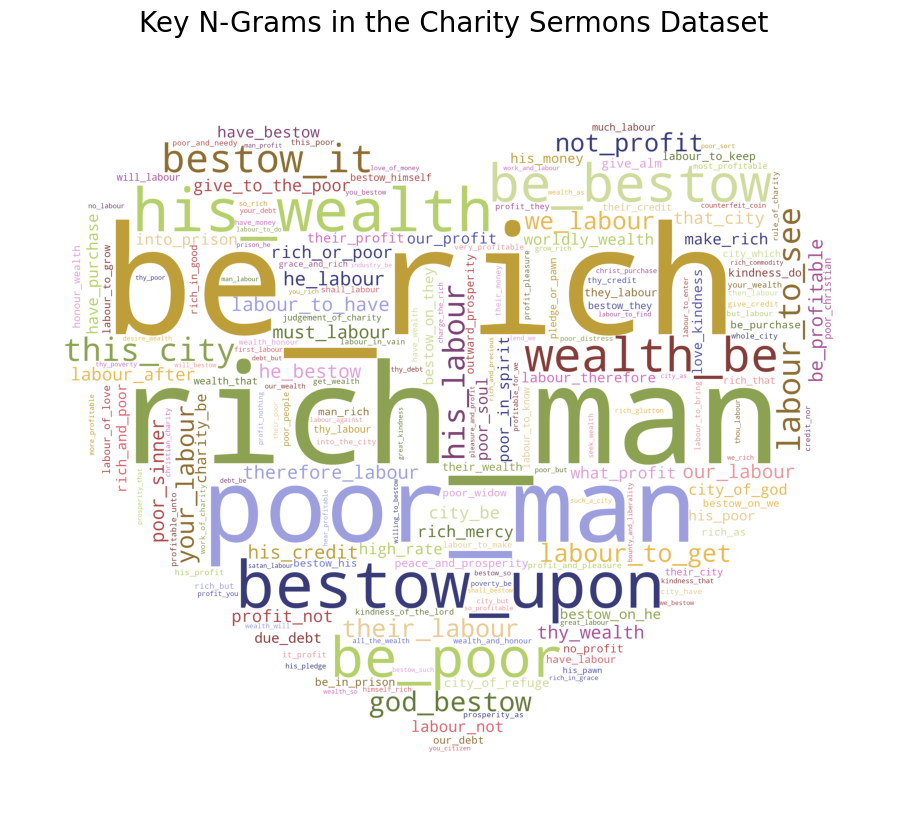

In [20]:
print(counts.most_common(n=50))
wordcloud(counts,"Key N-Grams in the Charity Sermons Dataset",True,maskable_image,'tab20b')

In [30]:
import re 
def getCounts(txt): 
    infile = open(txt,'r')
    lines = infile.readlines()
    infile.close()
    count = 0
    for line in lines:
        num = re.search(r'\b\d+\b',line)
        if num: 
            count += int(num.group())
    return count 
totalcount = getCounts('gramsEachcharityText.txt')
bgcount = getCounts('charityGrams.txt')
print(f'{bgcount} DIV {totalcount} = {bgcount/totalcount}')

5941 DIV 993505 = 0.005979839054660017
